# Seleção de características para aprovação de crédito

In [86]:
import time
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib

from csv import reader
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

In [48]:
# fixar a semente do gerador de números aleatórios
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [49]:
# mostrar todas as colunas do dataset
pd.set_option('display.max_columns', None)

### 1. Explorando o dataset

In [50]:
# carregando o dataset
df = pd.read_csv("datasets/application_data.csv", sep=",", encoding="latin-1")
df.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         351000.0    Unaccompanied               Working   
1        1129500.0           Family         State servant   
2         135000.0    Unaccompanied               Working   
3         297000.0    Unaccompanied               Working   
4         513000.0    Unaccompanied               Working   
5         454500.0  Spouse, partner         State servant   
6        1395000.0    Unaccompanied  Commercial associate   
7        1530000.0    Unaccompanied         State servant   
8         913500.0         Children             Pensioner   
9         405000.0    Unaccompanied               Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special               Married  House / apartment   
6               Higher education               Married  House / apartment   
7               Higher education               Married  House / apartment   
8  Secondary / secondary special               Married  House / apartment   
9  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   
5                    0.035792      -16941          -1588            -4970.0   
6                    0.035792      -13778          -3130            -1213.0   
7                    0.003122      -18850           -449            -4597.0   
8                    0.018634      -20099         365243            -7427.0   
9                    0.019689      -14469          -2019           -14437.

In [51]:
df.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [52]:
df["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [53]:
df["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [54]:
df["FLAG_OWN_CAR"].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [55]:
df["FLAG_OWN_REALTY"].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

### 2. Limpando o dataset

#### 2.1 Substituindo valores NaN

In [56]:
columns_with_null_values = []
    
for column in df:
    if df[column].isnull().any():
        columns_with_null_values.append(column)

len(columns_with_null_values)

67

In [57]:
df[columns_with_null_values].isnull().sum().sort_values(ascending = False)

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MODE    213514
                             ...  
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
Length: 67, dtype: int64

In [58]:
drop_columns = []
columns_to_analyze = []

for column in columns_with_null_values:
    if df[column].isnull().sum() > len(df)/2:
        drop_columns.append(column)
    else:
        columns_to_analyze.append(column)
        
len(drop_columns)

41

In [59]:
total_before_drop = len(df.columns)

df = df.drop(columns = drop_columns)
total_after_drop = len(df.columns)

print("{0} - {1} = {2}".format(total_before_drop, len(drop_columns), total_after_drop))

122 - 41 = 81


In [60]:
df[columns_to_analyze].isnull().sum().sort_values(ascending = False)

FLOORSMAX_MEDI                  153020
FLOORSMAX_AVG                   153020
FLOORSMAX_MODE                  153020
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BEGINEXPLUATATION_MEDI    150007
TOTALAREA_MODE                  148431
EMERGENCYSTATE_MODE             145755
OCCUPATION_TYPE                  96391
EXT_SOURCE_3                     60965
AMT_REQ_CREDIT_BUREAU_QRT        41519
AMT_REQ_CREDIT_BUREAU_YEAR       41519
AMT_REQ_CREDIT_BUREAU_HOUR       41519
AMT_REQ_CREDIT_BUREAU_DAY        41519
AMT_REQ_CREDIT_BUREAU_WEEK       41519
AMT_REQ_CREDIT_BUREAU_MON        41519
NAME_TYPE_SUITE                   1292
OBS_30_CNT_SOCIAL_CIRCLE          1021
DEF_30_CNT_SOCIAL_CIRCLE          1021
OBS_60_CNT_SOCIAL_CIRCLE          1021
DEF_60_CNT_SOCIAL_CIRCLE          1021
EXT_SOURCE_2                       660
AMT_GOODS_PRICE                    278
AMT_ANNUITY                         12
CNT_FAM_MEMBERS                      2
DAYS_LAST_PHONE_CHANGE   

In [61]:
df[columns_to_analyze].describe()

AMT_ANNUITY  AMT_GOODS_PRICE  CNT_FAM_MEMBERS  EXT_SOURCE_2  \
count  307499.000000     3.072330e+05    307509.000000  3.068510e+05   
mean    27108.573909     5.383962e+05         2.152665  5.143927e-01   
std     14493.737315     3.694465e+05         0.910682  1.910602e-01   
min      1615.500000     4.050000e+04         1.000000  8.173617e-08   
25%     16524.000000     2.385000e+05         2.000000  3.924574e-01   
50%     24903.000000     4.500000e+05         2.000000  5.659614e-01   
75%     34596.000000     6.795000e+05         3.000000  6.636171e-01   
max    258025.500000     4.050000e+06        20.000000  8.549997e-01   

        EXT_SOURCE_3  YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  \
count  246546.000000                157504.000000  154491.000000   
mean        0.510853                     0.977735       0.226282   
std         0.194844                     0.059223       0.144641   
min         0.000527                     0.000000       0.000000   
25%         0.370650                     0.976700       0.166700   
50%         0.535276                     0.981600       0.166700   
75%         0.669057                     0.986600       0.333300   
max         0.896010                     1.000000       1.000000   

       YEARS_BEGINEXPLUATATION_MODE  FLOORSMAX_MODE  \
count                 157504.000000   154491.000000   
mean                       0.977065        0.222315   
std                        0.064575        0.143709   
min                        0.000000        0.000000   
25%                        0.976700        0.166700   
50%                        0.981600        0.166700   
75%                        0.986600        0.333300   
max                        1.000000        1.000000   

       YEARS_BEGINEXPLUATATION_MEDI  FLOORSMAX_MEDI  TOTALAREA_MODE  \
count                 157504.000000   154491.000000   159080.000000   
mean                       0.977752        0.225897        0.102547   
std                        0.059897        0.145067        0.107462   
min                        0.000000        0.000000        0.000000   
25%                        0.976700        0.166700        0.041200   
50%                        0.981600        0.166700        0.068800   
75%                        0.986600        0.333300        0.127600   
max                        1.000000        1.000000        1.000000   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count             306490.000000             306490.000000   
mean                   1.422245                  0.143421   
std                    2.400989                  0.446698   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    2.000000                  0.000000   
max                  348.000000                 34.000000   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count             306490.000000             306490.000000   
mean                   1.405292                  0.100049   
std                    2.379803                  0.362291   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    2.000000                  0.000000   
max                  344.000000                 24.000000   

       DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_HOUR  \
count           307510.000000               265992.000000   
mean              -962.858788                    0.006402   
std                826.808487                    0.083849   
min              -4292.000000                    0.000000   
25%              -1570.000000                    0.000000   
50%               -757.000000                    0.000000   
75%               -274.000000                    0.000000   
max                  0.

In [62]:
# Listas com colunas de moda e mediana
mode_list = []
median_list = []

for column in columns_to_analyze:
    suffix = column[-4:]
    if suffix == "MODE":
        mode_list.append(column)
    elif suffix == "MEDI":
        median_list.append(column)

In [63]:
# MODA
mode_list.remove('EMERGENCYSTATE_MODE')

for column in mode_list:
    df[column] = df[column].fillna(df[column].mode()[0])

    columns_to_analyze.remove(column)

In [64]:
# MEDIANA
for column in median_list:
    df[column] = df[column].fillna(df[column].median())

    columns_to_analyze.remove(column)

In [65]:
# Lista com colunas médias
avg_list = []

for column in columns_to_analyze:
    suffix = column[-3:]
    prefix = column[:3]
    if suffix == "AVG" or prefix == "AMT" or prefix == "EXT" or df[column].isnull().sum() < 1050:
        avg_list.append(column)        

In [66]:
# MÉDIA
for column in avg_list:
    df[column] = df[column].fillna(df[column].mean())
    columns_to_analyze.remove(column)

In [67]:
df[columns_to_analyze].isnull().sum().sort_values(ascending = False)

EMERGENCYSTATE_MODE    145755
OCCUPATION_TYPE         96391
NAME_TYPE_SUITE          1292
dtype: int64

In [68]:
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna('Unaccompanied')
df['EMERGENCYSTATE_MODE'] = df['EMERGENCYSTATE_MODE'].fillna('Undefined')
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Other')

In [69]:
df.isnull().any()

SK_ID_CURR                    False
TARGET                        False
NAME_CONTRACT_TYPE            False
CODE_GENDER                   False
FLAG_OWN_CAR                  False
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     False
AMT_REQ_CREDIT_BUREAU_WEEK    False
AMT_REQ_CREDIT_BUREAU_MON     False
AMT_REQ_CREDIT_BUREAU_QRT     False
AMT_REQ_CREDIT_BUREAU_YEAR    False
Length: 81, dtype: bool

#### 2.2 Removendo colunas irrelevantes

In [70]:
remove_data = []

for column in df.columns:
    if column[:3] == 'EXT':
        remove_data.append(column)
    elif column[:8] == 'FLAG_DOC':
        remove_data.append(column)
        
len(remove_data)

22

In [71]:
df = df.drop(columns=remove_data, axis=1)

#### 2.3 Convertendo categóricas

In [72]:
df = pd.get_dummies(df)
df.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   
2      100004       0             0           67500.0    135000.0   
3      100006       0             0          135000.0    312682.5   
4      100007       0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0           -637            -3648.0            -2120           1   
1          -1188            -1186.0             -291           1   
2           -225            -4260.0            -2531           1   
3          -3039            -9833.0            -2437           1   
4          -3038            -4311.0            -3458           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  YEARS_BEGINEXPLUATATION_MODE  \
0                     0.972200       0.083300                        0.9722   
1                     0.985100       0.291700                        0.9851   
2                     0.977735       0.226282                        0.9871   
3                     0.977735       0.226282                        0.9871   
4                     0.977735       0.226282                        0.9871   

   FLOORSMAX_MODE  YEARS_BEGINEXPLUATATION_MEDI  FLOORSMAX_MEDI  \
0          0.0833                        0.9722          0.0833   
1       

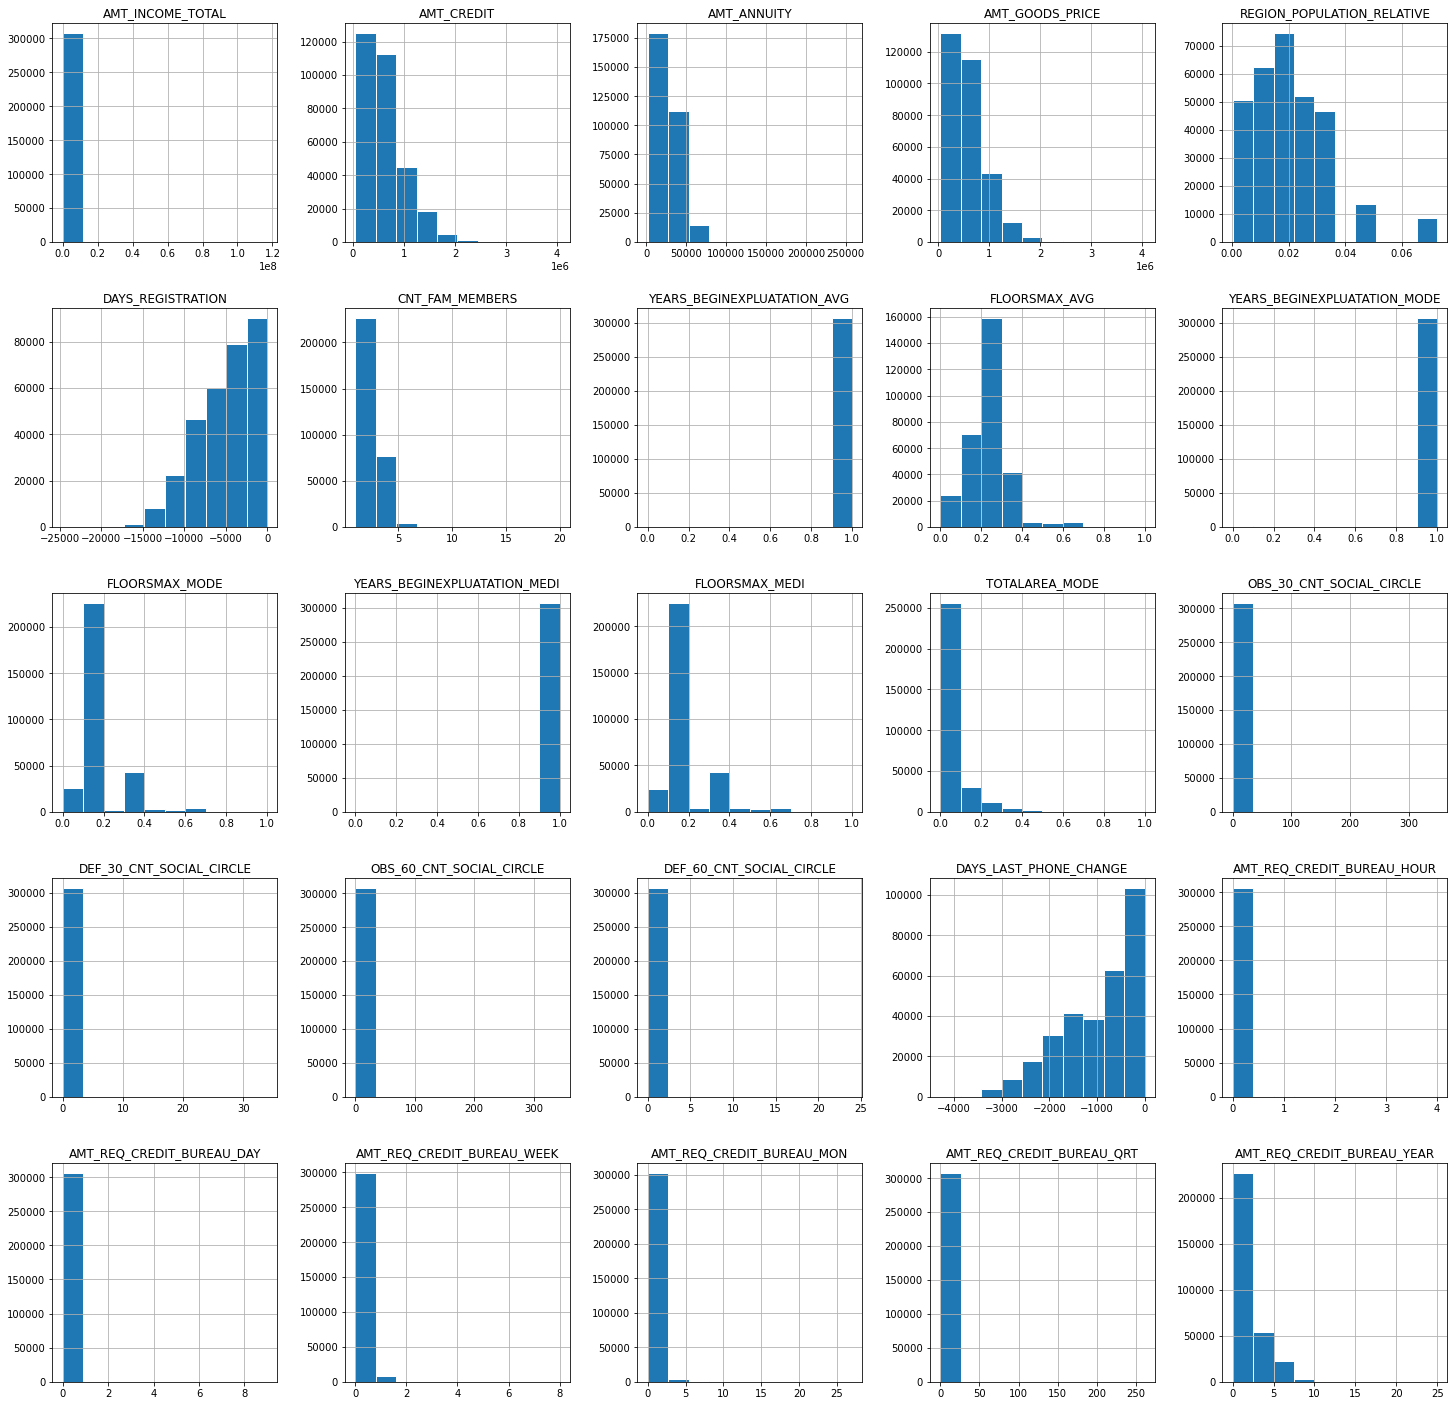

In [73]:
df.select_dtypes('float').hist(figsize=(25,25), ec='w')
plt.show()

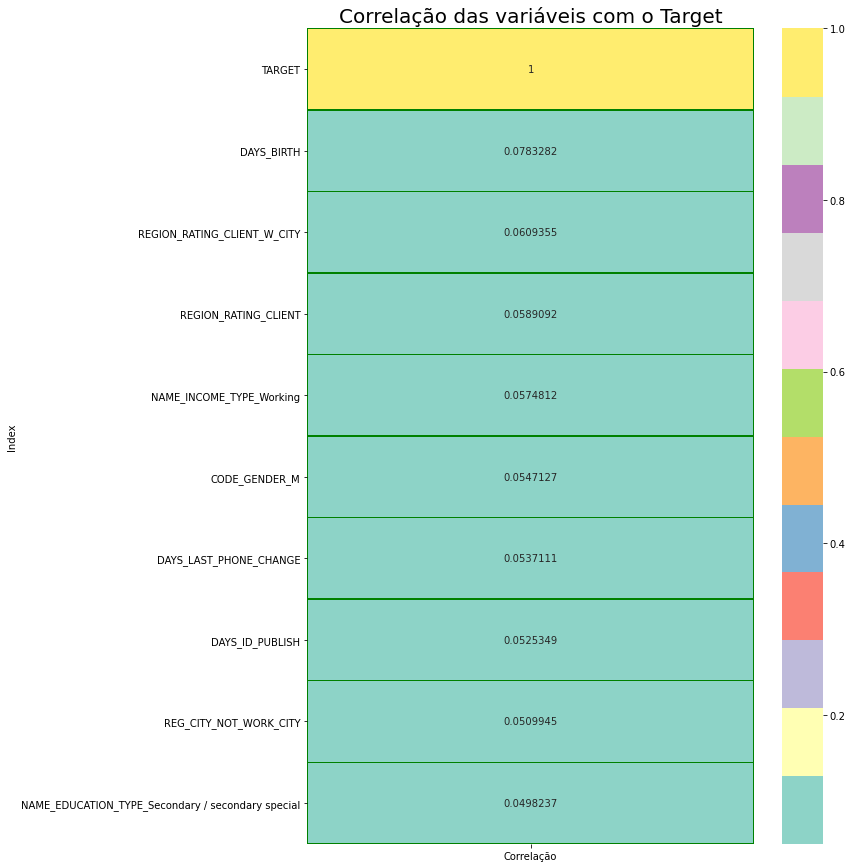

In [74]:
corr = df.corrwith(df['TARGET'],method='spearman').reset_index()

corr.columns = ['Index','Correlação']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlação'], ascending = False).head(10)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlação das variáveis com o Target", fontsize=20)
plt.show()

### 3. Dividindo conjuntos de teste e treinamento

In [75]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
print("{} train + {} test".format(len(train_set), len(test_set)))

246008 train + 61503 test


### 4. Correlação entre as features

In [76]:
def correlation_color(value):
    if value == 1:
        color = 'gold'
    elif abs(value) > 0.75:
        color = 'royalblue'
    elif value < 0:
        color = 'red'
    else:
        color = 'green'
    return 'color: %s' % color

In [77]:
pd.set_option('display.max_rows', None)
correlation = train_set.corr().style.applymap(correlation_color)
correlation

### 4. Separando a variável dependente: TARGET

In [78]:
x_train = train_set.drop(columns=["TARGET"])
y_train = train_set["TARGET"]
x_test = test_set.drop(columns=["TARGET"])
y_test = test_set["TARGET"]

### 5. Lasso Regression

RMSE: 0.26815817502947564

RSS: 4422.607346781547

Lasso escolheu 84 variáveis and eliminou outras 89 variáveis


AttributeError: 'Lasso' object has no attribute 'summary'

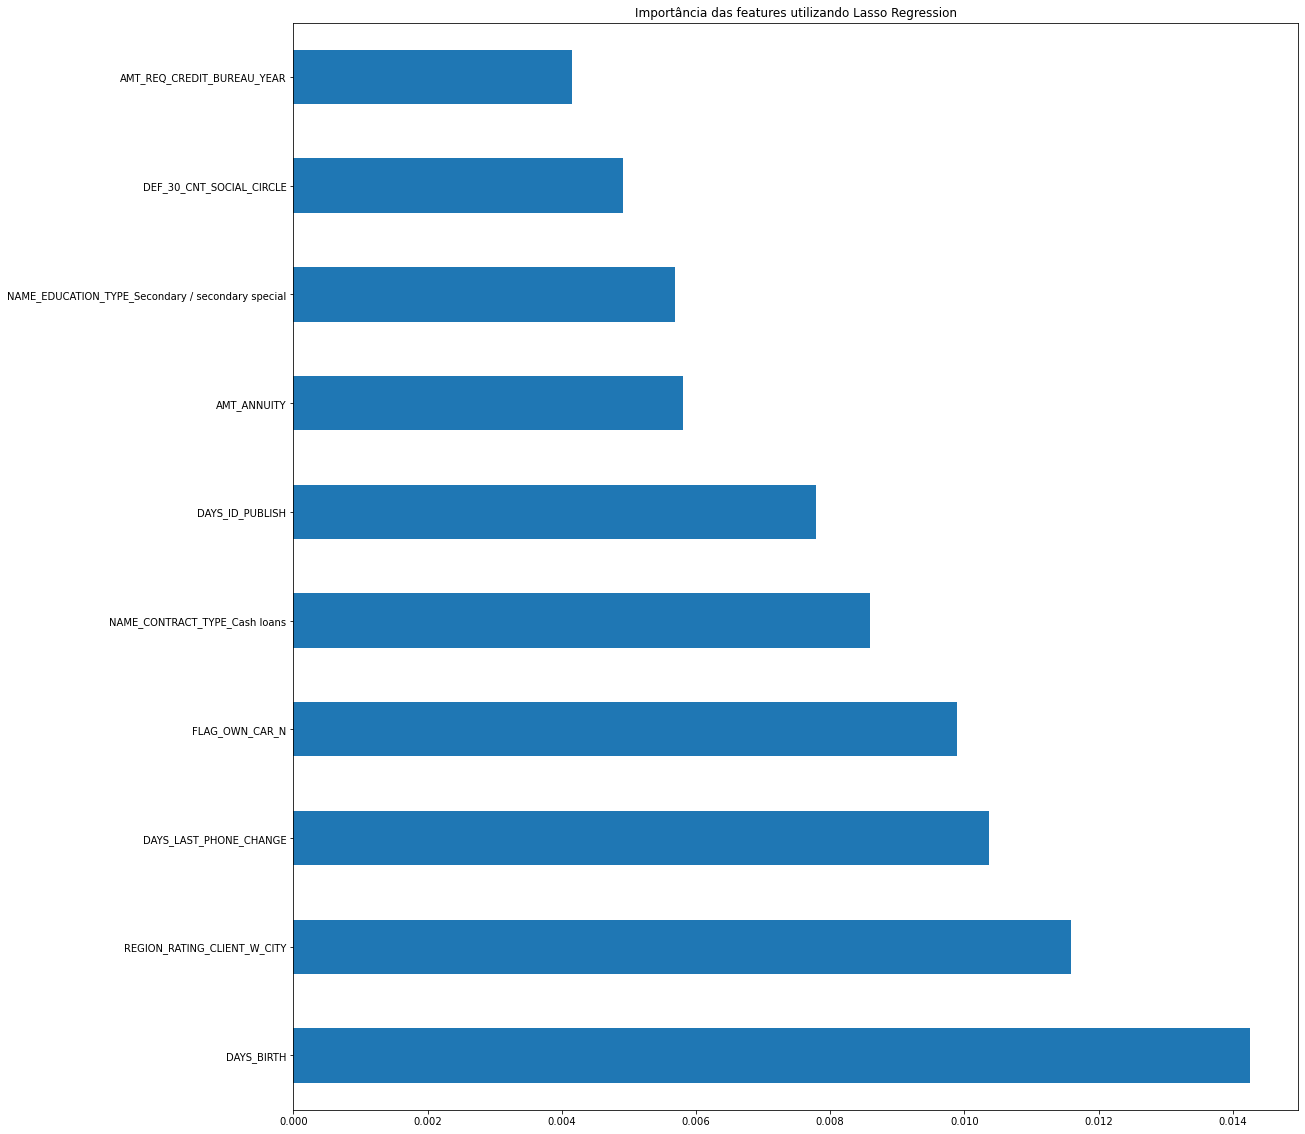

In [100]:
def experiment(msg, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
        
    model = pipeline.named_steps['lin_reg']
    #print('{}: \nintercept = {},\ncoefs = {}'.format(msg, model.intercept_, model.coef_))
    
    y_pred = pipeline.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
    print('RMSE: {}'.format(RMSE))
    print()
    RSS = ((pipeline.predict(X_test) - y_test) ** 2).sum()
    print('RSS: {}'.format(RSS))
    print()
    print("Lasso escolheu " + str(sum(model.coef_ != 0)) + " variáveis and eliminou outras " +  str(sum(model.coef_ == 0)) + " variáveis")
    coef = pd.Series(model.coef_, index = X_train.columns)
    imp_coef = coef.sort_values(ascending = False).head(10)
    matplotlib.rcParams['figure.figsize'] = (18.0, 20.0)
    imp_coef.plot(kind = "barh")
    plt.title("Importância das features utilizando Lasso Regression")
        
alpha = 1e-3

# Test o fit da regularização lasso.
reg_lasso = Pipeline([
        ("std_scaler", StandardScaler()), 
        ("lin_reg", Lasso(alpha=alpha))
    ])
experiment('Regularização Lasso', reg_lasso, x_train, y_train, x_test, y_test)

### 6. Forward Stepwise Selection

In [150]:
x_train_short = x_train[0:3000]
x_test_short = x_test[0:3000]
y_train_short = y_train[0:3000]
y_test_short = y_test[0:3000]

In [163]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train_short,x_train_short[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(x_test_short[list(feature_set)]) - y_test_short) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [164]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in x_train_short.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

RMSE = 0.2790774521361782

RSS: 233.63316735558053

In [165]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(x_train_short.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  173 models on 1 predictors in 0.9609169960021973 seconds.
Processed  172 models on 2 predictors in 0.9739851951599121 seconds.
Processed  171 models on 3 predictors in 0.9957082271575928 seconds.
Processed  170 models on 4 predictors in 1.407594919204712 seconds.
Processed  169 models on 5 predictors in 1.814037561416626 seconds.
Processed  168 models on 6 predictors in 2.4286110401153564 seconds.
Processed  167 models on 7 predictors in 2.0948095321655273 seconds.
Processed  166 models on 8 predictors in 2.2021238803863525 seconds.
Processed  165 models on 9 predictors in 3.211186170578003 seconds.
Processed  164 models on 10 predictors in 2.961435556411743 seconds.
Processed  163 models on 11 predictors in 3.6122491359710693 seconds.
Processed  162 models on 12 predictors in 2.408252716064453 seconds.
Processed  161 models on 13 predictors in 4.74567723274231 seconds.
Processed  160 models on 14 predictors in 3.9659295082092285 seconds.
Processed  159 models on 15 predicto

Processed  53 models on 121 predictors in 9.393619775772095 seconds.
Processed  52 models on 122 predictors in 9.330739259719849 seconds.
Processed  51 models on 123 predictors in 9.3017897605896 seconds.
Processed  50 models on 124 predictors in 9.22159719467163 seconds.
Processed  49 models on 125 predictors in 9.169350862503052 seconds.
Processed  48 models on 126 predictors in 9.12756061553955 seconds.
Processed  47 models on 127 predictors in 9.101420640945435 seconds.
Processed  46 models on 128 predictors in 8.574190139770508 seconds.
Processed  45 models on 129 predictors in 8.017160892486572 seconds.
Processed  44 models on 130 predictors in 7.966697692871094 seconds.
Processed  43 models on 131 predictors in 7.944979906082153 seconds.
Processed  42 models on 132 predictors in 7.747773170471191 seconds.
Processed  41 models on 133 predictors in 7.693588018417358 seconds.
Processed  40 models on 134 predictors in 7.5539398193359375 seconds.
Processed  39 models on 135 predictor

In [141]:
print(models_fwd.loc[10, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 TARGET   R-squared (uncentered):                   0.098
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              32.44
Date:                Sat, 28 Nov 2020   Prob (F-statistic):                    2.57e-60
Time:                        02:33:55   Log-Likelihood:                         -301.15
No. Observations:                3000   AIC:                                      622.3
Df Residuals:                    2990   BIC:                                      682.4
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--

In [154]:
model = sm.OLS(y_train_short,x_train_short)
regr = model.fit()
RSS = ((regr.predict(x_test_short) - y_test_short) ** 2).sum()
print(RSS)

239.11452778986546


In [99]:
model = sm.OLS(y_train,x_train)
regr = model.fit()
RSS = ((regr.predict(x_test) - y_test) ** 2).sum()
print(RSS)

C:\Users\giova\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


4406.062346718382


In [148]:
y_pred = regr.predict(x_test)
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
print(RMSE)

0.26765611438255776


### 7. Backward Elimination

In [158]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [159]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(x_train_short.columns)))

tic = time.time()
predictors = x_train_short.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  173 models on 172 predictors in 32.62027144432068 seconds.
Processed  172 models on 171 predictors in 31.380067348480225 seconds.
Processed  171 models on 170 predictors in 33.44111394882202 seconds.
Processed  170 models on 169 predictors in 26.842950105667114 seconds.
Processed  169 models on 168 predictors in 25.601804733276367 seconds.
Processed  168 models on 167 predictors in 25.887985706329346 seconds.
Processed  167 models on 166 predictors in 26.326761722564697 seconds.
Processed  166 models on 165 predictors in 27.637081384658813 seconds.
Processed  165 models on 164 predictors in 27.29721188545227 seconds.
Processed  164 models on 163 predictors in 24.31455898284912 seconds.
Processed  163 models on 162 predictors in 26.709601640701294 seconds.
Processed  162 models on 161 predictors in 25.346156358718872 seconds.
Processed  161 models on 160 predictors in 23.715494871139526 seconds.
Processed  160 models on 159 predictors in 22.927708387374878 seconds.
Processed 

Processed  55 models on 54 predictors in 3.3365464210510254 seconds.
Processed  54 models on 53 predictors in 3.1475164890289307 seconds.
Processed  53 models on 52 predictors in 3.397155523300171 seconds.
Processed  52 models on 51 predictors in 3.4322993755340576 seconds.
Processed  51 models on 50 predictors in 3.3042125701904297 seconds.
Processed  50 models on 49 predictors in 3.0674285888671875 seconds.
Processed  49 models on 48 predictors in 2.786069393157959 seconds.
Processed  48 models on 47 predictors in 2.793506383895874 seconds.
Processed  47 models on 46 predictors in 2.7962450981140137 seconds.
Processed  46 models on 45 predictors in 2.858722686767578 seconds.
Processed  45 models on 44 predictors in 2.3587486743927 seconds.
Processed  44 models on 43 predictors in 2.255948066711426 seconds.
Processed  43 models on 42 predictors in 2.149975061416626 seconds.
Processed  42 models on 41 predictors in 2.203063488006592 seconds.
Processed  41 models on 40 predictors in 2.0

RMSE: 0.28232700920946746

RSS: 239.1256203874882

In [160]:
print(models_bwd.loc[10, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 TARGET   R-squared (uncentered):                   0.098
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              32.33
Date:                Sat, 28 Nov 2020   Prob (F-statistic):                    4.31e-60
Time:                        22:24:52   Log-Likelihood:                         -301.68
No. Observations:                3000   AIC:                                      623.4
Df Residuals:                    2990   BIC:                                      683.4
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--

In [161]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[10, "model"].params)

-----------------
Foward Selection:
-----------------


KeyError: 10

In [162]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[10, "model"].params)

-------------------
Backward Selection:
-------------------
AMT_CREDIT                                           1.475850e-07
AMT_GOODS_PRICE                                     -1.697462e-07
DAYS_BIRTH                                           4.283416e-06
FLAG_CONT_MOBILE                                     8.995334e-02
REGION_RATING_CLIENT_W_CITY                          2.805088e-02
DAYS_LAST_PHONE_CHANGE                               1.486221e-05
CODE_GENDER_F                                       -2.376714e-02
FLAG_OWN_CAR_N                                       1.614297e-02
NAME_EDUCATION_TYPE_Secondary / secondary special    3.266715e-02
OCCUPATION_TYPE_Low-skill Laborers                   1.338449e-01
dtype: float64


In [ ]:
x_train.head(25)

In [35]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [40]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(x_train_short, y_train_short)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  7.4min finished

[2020-11-27 01:41:04] Features: 1/5 -- score: 0.915[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  7.6min finished

[2020-11-27 01:48:38] Features: 2/5 -- score: 0.916[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:  8.3min finished

[2020-11-27 01:56:58] Features: 3/5 -- score: 0.916[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining

In [41]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[11, 14, 21, 27, 50]


11 -> flag_mobil
14 -> flag_cont_mobile
21 -> REG_REGION_NOT_LIVE_REGION
27 -> YEARS_BEGINEXPLUATATION_AVG
50 -> FLAG_OWN_CAR_N	

In [144]:
# Build full model with selected features
feat_cols = ['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'YEARS_BEGINEXPLUATATION_AVG', 'FLAG_OWN_CAR_N']
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(x_train[feat_cols], y_train)

y_train_pred = clf.predict(x_train[feat_cols])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(x_test[feat_cols])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.919
Testing accuracy on selected features: 0.920


In [146]:
RSS = ((clf.predict(x_test[feat_cols]) - y_test) ** 2).sum()
print(RSS)

4949


In [50]:
# Build full model on ALL features, for comparison
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
print('Training accuracy on all features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(x_test)
print('Testing accuracy on all features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on all features: 0.919
Testing accuracy on all features: 0.920


In [36]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step backward feature selection
sbs = sfs(clf,
           k_features=5,
           forward=False,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SBS
sbs = sbs.fit(x_train_short, y_train_short)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  5.2min finished

[2020-11-27 21:41:15] Features: 172/5 -- score: 0.9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [37]:
# Which features?
feat_cols = list(sbs.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171]


In [ ]:
# Build full model with selected features
feat_cols = []
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(x_train[feat_cols], y_train)

y_train_pred = clf.predict(x_train[feat_cols])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf.predict(x_test[feat_cols])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))